# Feature Selection and Feature Engineering

Featuring an exploration of polynomial and interaction terms (postponed from last Thursday!)

## Objectives

- Use correlations and other algorithms to inform feature selection
- Address the problem of multicollinearity in regression problems
- Create new features for use in modeling
    - Use `PolynomialFeatures` to build compound features

## Set Up

Insurance costs data (from https://www.kaggle.com/mirichoi0218/insurance)

In [1]:
# Initial imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv('data/insurance.csv')

In [3]:
# explore the data
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Let's quickly encode our categorical variables to use!

In [6]:
# set our X and y
X = df.drop(columns='charges')
y = df['charges']

In [7]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [8]:
cat_cols = ['sex', 'smoker', 'region']

# create an encoder object
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

# Create an columntransformer object
ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')
ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [9]:
# We can also go ahead and scale - let's use a MinMaxScaler because binaries!
scaler = MinMaxScaler()

# train on train data
scaler.fit(X_train_enc)

# transform both train and test data
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [10]:
X_train_sc_df = pd.DataFrame(X_train_scaled, columns= ct.get_feature_names())
X_train_sc_df.head()

,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,1.0,0.0,1.0,0.0,0.0,0.130435,0.207022,0.0
1,0.0,0.0,0.0,1.0,0.0,0.217391,0.283831,0.4
2,1.0,0.0,0.0,0.0,1.0,0.717391,0.638687,0.2
3,1.0,1.0,0.0,1.0,0.0,0.630435,0.541297,0.2
4,0.0,0.0,0.0,0.0,1.0,0.608696,0.348130,0.4


# Correlation and Multicollinearity

Our first attempt might be just see which features are _correlated_ with the target to make a prediction.

We can use the correlation metric in making a decision.

In [11]:
# want to create a full train df with both X and y variables to explore
train_df = pd.DataFrame(X_train_enc, columns= ct.get_feature_names())
train_df['target'] = y_train

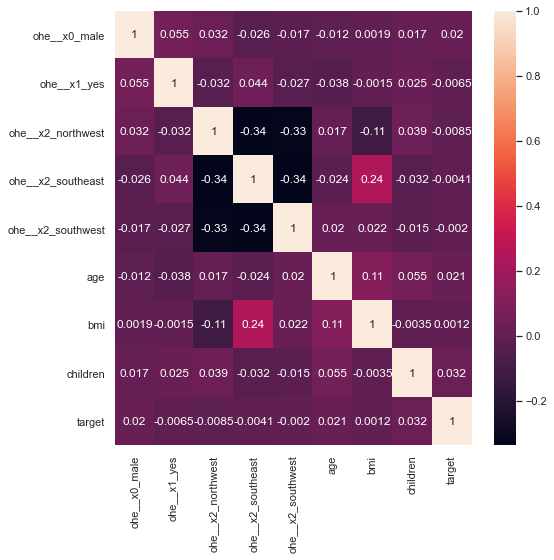

In [12]:
# Makign the visual bigger so we can read it
sns.set(rc={'figure.figsize':(8, 8)})

sns.heatmap(train_df.corr(), annot=True);

In [13]:
# Let's zoom in on the correlations with 'charges' (target)
train_df.corr()['target'].map(abs).sort_values(ascending=False)

target               1.000000
children             0.031751
age                  0.021475
ohe__x0_male         0.019636
ohe__x2_northwest    0.008468
ohe__x1_yes          0.006471
ohe__x2_southeast    0.004112
ohe__x2_southwest    0.001995
bmi                  0.001221
Name: target, dtype: float64

You'll notice that none of these features are super strongly correlated with our target... so it's not surprising if a model of these features on this target doesn't perform particularly well!

But, let's try to model, first with just the most correlated feature (`children`) and then with all features, and see how they perform.

In [14]:
# Instantiate our simple model
lr_simple = LinearRegression()

# Run with our most strongly correlated feature
lr_simple.fit(X_train_sc_df[['children']], y_train)

# Score on train
print(f"Train R2: {lr_simple.score(X_train_sc_df[['children']], y_train):.4f}")

# Make a df version of test to score it too
X_test_sc_df = pd.DataFrame(X_test_scaled, columns= ct.get_feature_names())
print(f"Test R2: {lr_simple.score(X_test_sc_df[['children']], y_test):.4f}")

Train R2: 0.0064
Test R2: -0.0009


#### Evaluate 

- VERY BAD


In [15]:
# Instantiate our model
lr_all = LinearRegression()

# Run with all features
lr_all.fit(X_train_scaled, y_train)

# Score on train and test
print(f"Train R2: {lr_all.score(X_train_scaled, y_train):.4f}")
print(f"Test R2: {lr_all.score(X_test_scaled, y_test):.4f}")

Train R2: 0.7450
Test R2: 0.7673


#### Evaluate 

- 


### Explore Coefficients

Our simple model with just one variable performed quite poorly, but our more complicated model performed much better. 

Let's explore the coefficients of that model:


In [16]:
dict(zip(ct.get_feature_names(), lr_all.coef_))

{'ohe__x0_male': 45.62242749280853,
 'ohe__x1_yes': 23630.398990299247,
 'ohe__x2_northwest': -355.14862132651433,
 'ohe__x2_southeast': -781.3683889164677,
 'ohe__x2_southwest': -860.2667122325365,
 'age': 11942.687121967849,
 'bmi': 12630.553003885027,
 'children': 2132.5136137240097}

BECAUSE our data is all on the same scale, we can use coefficients to decide which are more important in this model!

Let's run another model with only the top 4 features with the largest coefficients (by absolute value)

In [17]:
# Define our top four features for train and test
top4 = ['ohe__x1_yes', 'age', 'bmi', 'children']
# Easiest to do this with a dataframe
X_train_top4 = X_train_sc_df[top4]
X_test_top4 = X_test_sc_df[top4]

In [18]:
# Instantiate our model
lr_top4 = LinearRegression()

# Run with all features
lr_top4.fit(X_train_top4, y_train)

# Score on train and test
print(f"Train R2: {lr_top4.score(X_train_top4, y_train):.4f}")
print(f"Test R2: {lr_top4.score(X_test_top4, y_test):.4f}")

Train R2: 0.7442
Test R2: 0.7654


#### Evaluate

- 


## Recursive Feature Elimination

The idea behind recursive feature elimination is to start with all predictive features and then build down to a small set of features slowly, by eliminating the features with the lowest coefficients.

That is:

1. Start with a model with _all_ $n$ predictors
2. find the predictor with the smallest effect (coefficient)
3. throw that predictor out and build a model with the remaining $n-1$ predictors
4. set $n = n-1$ and repeat until $n-1$ has the value you want!

### Recursive Feature Elimination in Scikit-Learn

Note: MUST use on scaled data!

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [19]:
# import RFE
from sklearn.feature_selection import RFE

In [35]:
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=3, verbose=1)

In [36]:
select.fit(X=X_train_scaled, y=y_train)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.


RFE(estimator=LinearRegression(), n_features_to_select=3, verbose=1)

In [37]:
select.support_

array([False,  True, False, False, False,  True,  True, False])

In [38]:
select.ranking_

array([6, 1, 5, 4, 3, 1, 1, 2])

There are more options built out in SKLearn - check out their [user guide section on feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)!

-----

# Feature Engineering

## Polynomial Terms - Simple Linear Regression

Demonstrating this on a toy example, with a single x variable predicting y.

In [39]:
# 150 samples from uniform distribution between -2pi and 2pi

x = np.random.uniform(-2*np.pi, 2*np.pi, 150)

# Creating target (y) - so we know the true relationship between x and y
# But - adding some noise (error) with 'np.random'

y = np.sin(x) + np.random.normal(loc=0, scale=0.4, size=len(x))

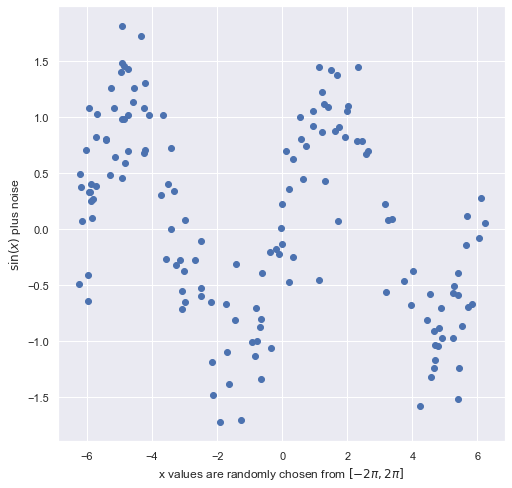

In [40]:
# Visualize it
plt.scatter(x, y)

plt.ylabel('$\sin(x)$ plus noise')
plt.xlabel('x values are randomly chosen from $[-2\pi, 2\pi]$')
plt.show()

In [41]:
# Fitting a linear model
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y)

LinearRegression()

In [42]:
# Grabbing the predicted values
y_pred = lr.predict(x.reshape(-1, 1))

In [43]:
# Scoring our model
print(f"R2 Score: {r2_score(y, y_pred)}")

R2 Score: 0.14565082017811415


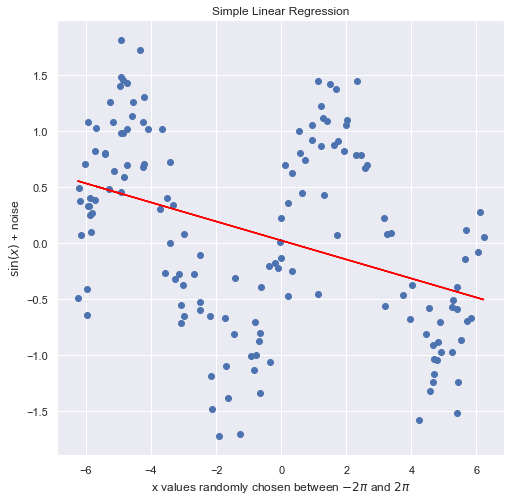

In [44]:
# Visualize it
plt.scatter(x, y) # original data

plt.plot(x, y_pred, c='red') # predicted values

plt.ylabel('$\sin(x)$ + noise')
plt.xlabel('x values randomly chosen between $-2\pi$ and $2\pi$')
plt.title("Simple Linear Regression")

plt.show()

Is this a good model? Well - of course not. It's definitely **underfit** - it is not complex enough to accurately capture the pattern and predict the target.

Let's try again, but now with polynomials!

In [45]:
# For this, we'll need some helper functions
# Shoutout to Andy for sending me these
from sklearn.preprocessing import PolynomialFeatures

def create_poly_dataset(x, degree):
    """
    returning dataset with the given polynomial degree
    """
    # Instantiate the PolynomialFeatures object with given 'degree'
    poly = PolynomialFeatures(degree=degree)

    # Now transform data to create higher order features
    new_data = poly.fit_transform(x.reshape(-1, 1))
    return new_data

def fit_linear_model(data, y):
    """
    fitting a linear model and printing model details
    """
    np.set_printoptions(precision=4, suppress=True)

    if data.ndim == 1:
        data = data.reshape(-1, 1)

    lr = LinearRegression(fit_intercept=False)
    lr.fit(data, y)
    print("-"*13)
    print("Coefficients: ", lr.coef_)
    y_pred = lr.predict(data)
    print(f"R-Squared: {lr.score(data, y):.3f}")
    return lr

def plot_predict(x, y, model):
    """
    plotting predictions against true values
    """
    plt.scatter(x, y, label='true')
    x_pred = np.linspace(x.min(), x.max(), 100)
    
    # visualize beyond this x range by uncommenting below:
#     extra = x.ptp() * .2
#     x_pred = np.linspace(x.min() - extra, x.max() + extra, 100)

    plt.plot(x_pred, model.predict(create_poly_dataset(x_pred, len(model.coef_)-1)),
             label='predicted', c='red')

    if len(model.coef_) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms \n (no slope)")
    elif (len(model.coef_) - 1) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Term")
    else:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms")

    plt.legend()
    plt.show()
    return

-------------
Coefficients:  [0.0778]
R-Squared: -0.000


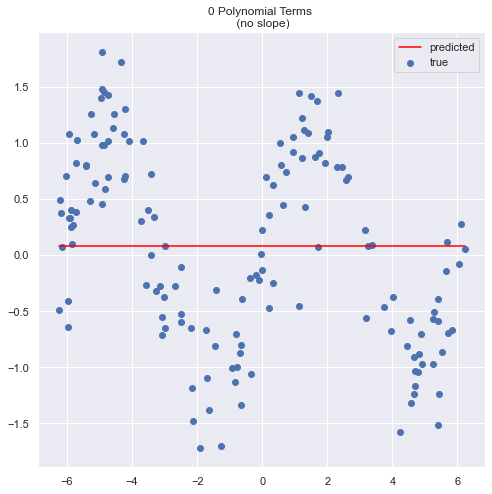

-------------
Coefficients:  [ 0.0234 -0.0848]
R-Squared: 0.146


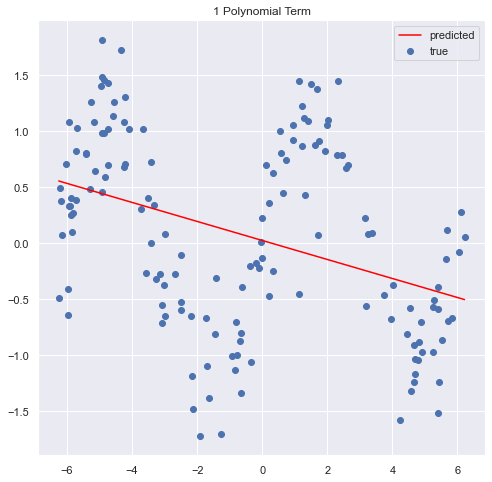

-------------
Coefficients:  [ 0.0275 -0.0849 -0.0003]
R-Squared: 0.146


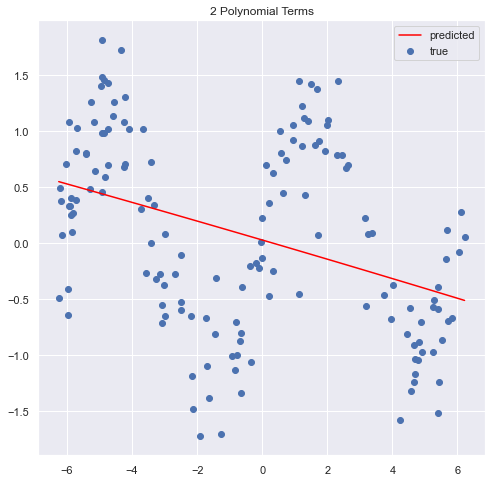

-------------
Coefficients:  [ 0.0613  0.066  -0.003  -0.0059]
R-Squared: 0.210


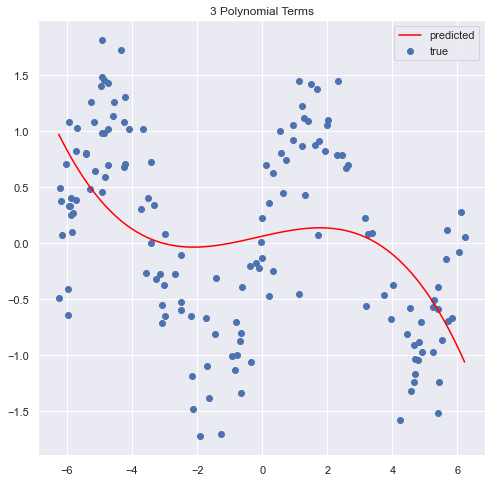

-------------
Coefficients:  [-0.0464  0.7226  0.0091 -0.0779 -0.0001  0.0016]
R-Squared: 0.741


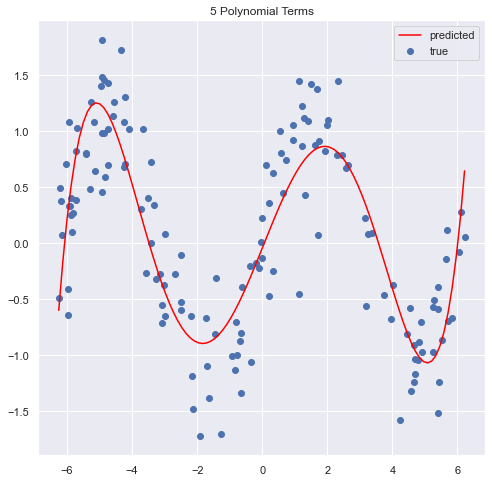

-------------
Coefficients:  [-0.0871  1.0206  0.0141 -0.1459 -0.0005  0.0053  0.     -0.0001]
R-Squared: 0.801


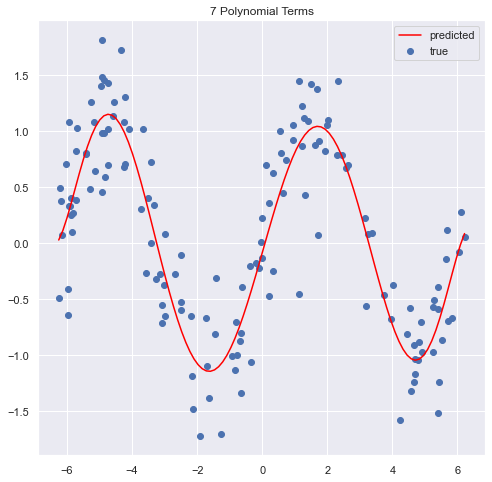

-------------
Coefficients:  [-0.0722  1.0419 -0.002  -0.1539  0.0017  0.0061 -0.0001 -0.0001  0.
  0.    ]
R-Squared: 0.801


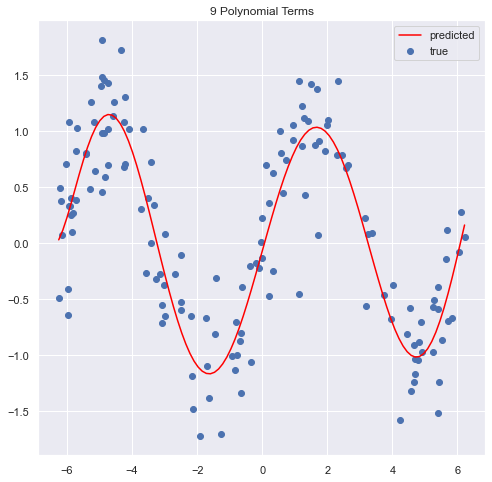

-------------
Coefficients:  [-0.0772  1.1153  0.0043 -0.2085  0.0008  0.0173 -0.0001 -0.0011  0.
  0.     -0.     -0.      0.      0.    ]
R-Squared: 0.802


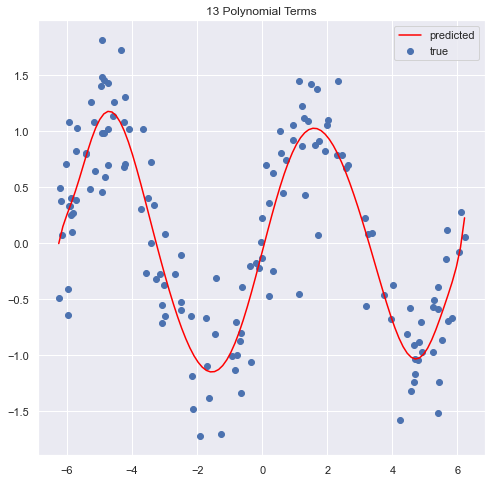

-------------
Coefficients:  [-0.006   1.2832 -0.2733 -0.3927  0.1756  0.0778 -0.0426 -0.01    0.0053
  0.0007 -0.0004 -0.      0.      0.     -0.     -0.      0.      0.
 -0.    ]
R-Squared: 0.807


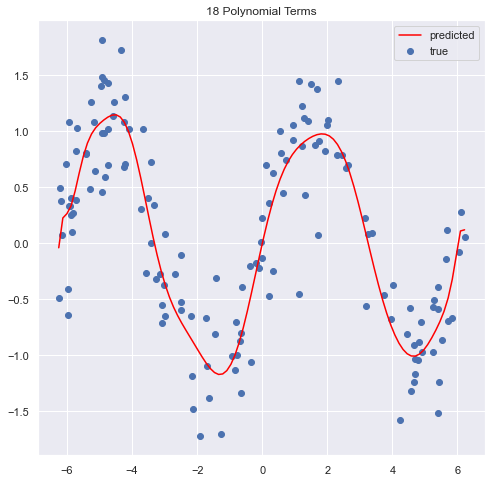

In [46]:
# visualizing an assortment of polynomial degrees
# can visualize each sequential polynomial with `range(n)`
for i in [0, 1, 2, 3, 5, 7, 9, 13, 18]:
    xi = create_poly_dataset(x, i)
    plot_predict(x, y, fit_linear_model(xi, y))

Evaluate: which of these is the best?

- 


Evaluate: so what?

- 


## Interaction Terms

When do we need interaction terms? And how do we check for them?

Well, first things first - what interactions do _you_ think would make sense? That's the easiest way to incorporate interaction terms - use domain knowledge to think through what usefully could be combined into an interaction.

As for how to check if something might be better captured as an interaction...

In [47]:
# Quick set up
df_ohe = pd.get_dummies(df, columns=cat_cols, drop_first=True)

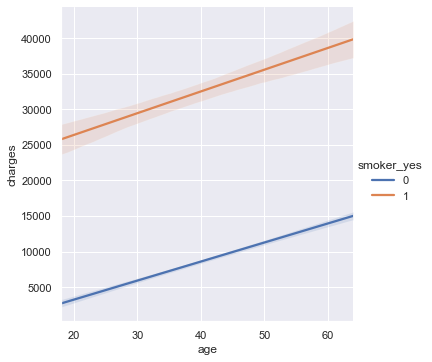

In [48]:
# an example of no interaction term...
sns.lmplot(x='age', y='charges', hue='smoker_yes', data=df_ohe, scatter=False)
plt.show()

How do I know these two variables, `age` and `smoker_yes`, aren't interacting? 

- 


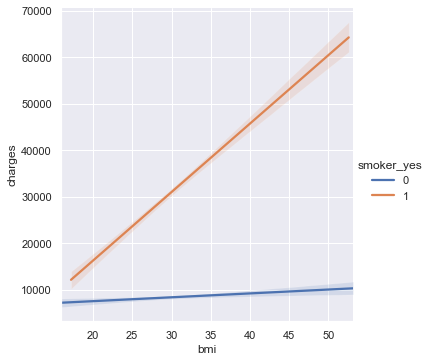

In [49]:
# now let's look at something else...
sns.lmplot(x='bmi', y='charges', hue='smoker_yes', data=df_ohe, scatter=False)
plt.show()

What do you think?

- 


## Implementing Interaction and Polynomials in Sklearn

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [50]:
# There's a sklearn function for both!
from sklearn.preprocessing import PolynomialFeatures

Let's first do Polynomials, to the 3rd degree:

In [51]:
# Set up our PolynomialFeatures with degree=3 and interaction_only=False
poly = PolynomialFeatures(degree=3, interaction_only=False)

In [52]:
poly.fit(X_train_scaled)

PolynomialFeatures(degree=3)

In [53]:
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [54]:
X_train_poly = pd.DataFrame(X_train_poly, columns = poly.get_feature_names())
X_train_poly.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x0^2,...,x5^3,x5^2 x6,x5^2 x7,x5 x6^2,x5 x6 x7,x5 x7^2,x6^3,x6^2 x7,x6 x7^2,x7^3
0,1.0,1.0,0.0,1.0,0.0,0.0,0.130435,0.207022,0.0,1.0,...,0.002219,0.003522,0.000000,0.005590,0.000000,0.000000,0.008873,0.000000,0.000000,0.000
1,1.0,0.0,0.0,0.0,1.0,0.0,0.217391,0.283831,0.4,0.0,...,0.010274,0.013414,0.018904,0.017513,0.024681,0.034783,0.022865,0.032224,0.045413,0.064
2,1.0,1.0,0.0,0.0,0.0,1.0,0.717391,0.638687,0.2,1.0,...,0.369206,0.328701,0.102930,0.292639,0.091638,0.028696,0.260534,0.081584,0.025547,0.008
3,1.0,1.0,1.0,0.0,1.0,0.0,0.630435,0.541297,0.2,1.0,...,0.250565,0.215137,0.079490,0.184719,0.068250,0.025217,0.158601,0.058600,0.021652,0.008
4,1.0,0.0,0.0,0.0,0.0,1.0,0.608696,0.348130,0.4,0.0,...,0.225528,0.128986,0.148204,0.073771,0.084762,0.097391,0.042192,0.048478,0.055701,0.064


In [56]:
X_train_poly.columns

Index(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x0^2',
       ...
       'x5^3', 'x5^2 x6', 'x5^2 x7', 'x5 x6^2', 'x5 x6 x7', 'x5 x7^2', 'x6^3',
       'x6^2 x7', 'x6 x7^2', 'x7^3'],
      dtype='object', length=165)

In [57]:
X_train_poly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Columns: 165 entries, 1 to x7^3
dtypes: float64(165)
memory usage: 1.3 MB


In [58]:
# Model!
lr_poly = LinearRegression()

lr_poly.fit(X_train_poly, y_train)

train_poly_preds = lr_poly.predict(X_train_poly)
test_poly_preds = lr_poly.predict(X_test_poly)

In [59]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train, train_poly_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, test_poly_preds):.3f}")

Train R2 Score: 0.857
Test R2 Score: 0.839


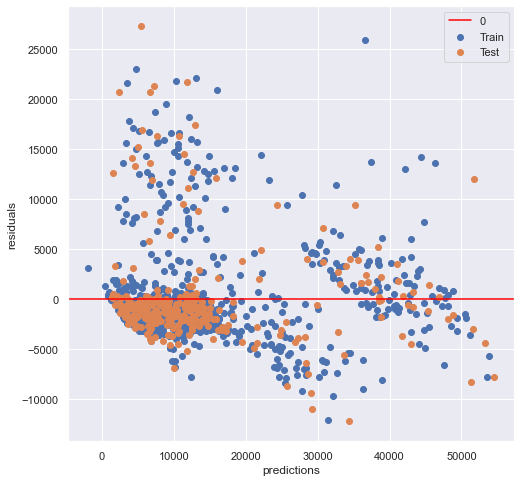

In [60]:
# visualize residuals, for the model that now has many polynomial cols
plt.scatter(train_poly_preds, y_train-train_poly_preds, label='Train')
plt.scatter(test_poly_preds, y_test-test_poly_preds, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

----

In [61]:
# Now let's set up interactions: degree=2, interaction_only=True
interactions = PolynomialFeatures(degree=2, interaction_only=True)

interactions.fit(X_train_scaled)

PolynomialFeatures(interaction_only=True)

In [62]:
X_train_ints = interactions.transform(X_train_scaled)
X_test_ints = interactions.transform(X_test_scaled)

In [63]:
X_train_ints = pd.DataFrame(X_train_ints, columns = interactions.get_feature_names())
X_train_ints.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x0 x1,...,x3 x4,x3 x5,x3 x6,x3 x7,x4 x5,x4 x6,x4 x7,x5 x6,x5 x7,x6 x7
0,1.0,1.0,0.0,1.0,0.0,0.0,0.130435,0.207022,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.027003,0.000000,0.000000
1,1.0,0.0,0.0,0.0,1.0,0.0,0.217391,0.283831,0.4,0.0,...,0.0,0.217391,0.283831,0.4,0.000000,0.000000,0.0,0.061702,0.086957,0.113532
2,1.0,1.0,0.0,0.0,0.0,1.0,0.717391,0.638687,0.2,0.0,...,0.0,0.000000,0.000000,0.0,0.717391,0.638687,0.2,0.458189,0.143478,0.127737
3,1.0,1.0,1.0,0.0,1.0,0.0,0.630435,0.541297,0.2,1.0,...,0.0,0.630435,0.541297,0.2,0.000000,0.000000,0.0,0.341252,0.126087,0.108259
4,1.0,0.0,0.0,0.0,0.0,1.0,0.608696,0.348130,0.4,0.0,...,0.0,0.000000,0.000000,0.0,0.608696,0.348130,0.4,0.211905,0.243478,0.139252


In [64]:
# Model!
lr_int = LinearRegression()

lr_int.fit(X_train_ints, y_train)

train_ints_preds = lr_int.predict(X_train_ints)
test_ints_preds = lr_int.predict(X_test_ints)

In [65]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train, train_ints_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, test_ints_preds):.3f}")

Train R2 Score: 0.841
Test R2 Score: 0.851


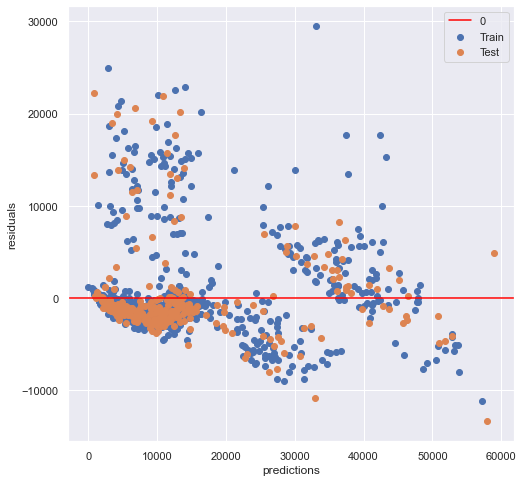

In [66]:
# visualize residuals, for the model that now has interaction cols
plt.scatter(train_ints_preds, y_train-train_ints_preds, label='Train')
plt.scatter(test_ints_preds, y_test-test_ints_preds, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

Evaluate: What do you think? Is this blanket way of approaching polynomial or interaction terms useful?

- 


## Resources:

[Feature Engineering and Selection: A Practical Approach for Predictive Models](https://bookdown.org/max/FES/) (computing done in R, but book focuses mostly on discussing the hows and whys rather than focusing on implementation)

- And their chapter on [Detecting Interaction Effects](https://bookdown.org/max/FES/detecting-interaction-effects.html)